In [24]:
import os
import pandas as pd
import numpy as np
from scipy.stats import kurtosis
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
from datetime import datetime,timedelta
# Define constants
CHANNEL_MAP = {
    1: (0, 1),
    2: (2, 3),
    3: (4, 5),
    4: (6, 7)
}
DATA_PATH = r'/Users/pankajti/dev/data/kaggle/nasa/archive (1)/1st_test/1st_test'
SAMPLING_RATE = 20000  # 20 kHz
WINDOW_SIZE = 400
SECONDS_PER_FILE = 1  # Each file is a 1-second snapshot

In [25]:
# Extract timestamp from filename
from tqdm import tqdm
def extract_timestamp(filename):
    base_name = os.path.basename(filename)
    timestamp_str = base_name.replace('.', '-')  # e.g., '2003.10.22.12.06.24' to '2003-10-22-12-06-24'
    return datetime.strptime(timestamp_str, '%Y-%m-%d-%H-%M-%S')

# Function to extract rolling features with timestamp per sliding window
def extract_features_with_timestamps(bearing_number=3):
    files = sorted(os.listdir(DATA_PATH))
    all_features = []
    all_timestamps = []

    for file in tqdm(files):
        file_path = os.path.join(DATA_PATH, file)
        #print(f"reading file {file_path}")

        if not os.path.exists(file_path):
            continue
        try:
            data = pd.read_table(file_path, header=None)
            ch1, ch2 = CHANNEL_MAP[bearing_number]
            signal = data.iloc[:, ch2].values
            base_timestamp = extract_timestamp(file)

            # Generate sliding windows
            for i in range(0, len(signal) - WINDOW_SIZE + 1, WINDOW_SIZE):
                window = signal[i:i + WINDOW_SIZE]
                if len(window) == WINDOW_SIZE:
                    feat = [
                        np.mean(window),
                        np.std(window),
                        kurtosis(window)
                    ]
                    # Each window spans window_size/SAMPLING_RATE seconds
                    delta_seconds = i / SAMPLING_RATE
                    timestamp = base_timestamp + timedelta(seconds=delta_seconds)
                    all_features.append(feat)
                    all_timestamps.append(timestamp)
        except Exception as e:
            print(f"Failed to read {file_path}: {e}")
            raise e

    df = pd.DataFrame(all_features, columns=['mean', 'std', 'kurtosis'])
    df['timestamp'] = all_timestamps
    return df

In [26]:

# Generate RUL labels
def generate_rul_labels(num_samples):
    return np.arange(num_samples - 1, -1, -1).reshape(-1, 1)

# Main processing
features = extract_features_with_timestamps(bearing_number=3)
features = features.set_index('timestamp')
rul_labels = generate_rul_labels(len(features))

# Normalize features and labels
scaler_X = MinMaxScaler()
scaler_y = MinMaxScaler()
features_scaled = scaler_X.fit_transform(features)
rul_scaled = scaler_y.fit_transform(rul_labels)


100%|███████████████████████████████████████| 2156/2156 [00:27<00:00, 79.01it/s]


<Axes: xlabel='timestamp'>

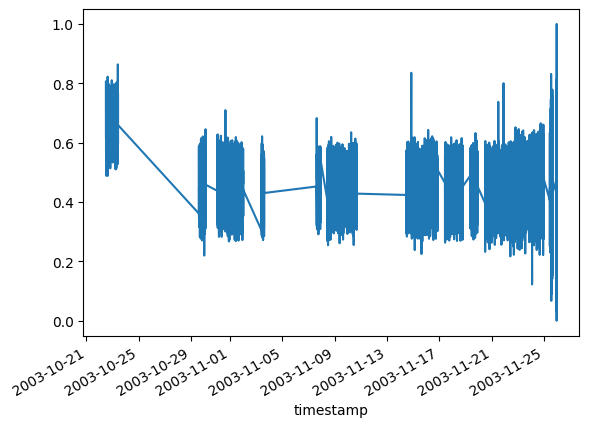

In [27]:
# Combine for display
processed_data = pd.DataFrame(features_scaled, columns=['mean', 'std', 'kurtosis'],index=features.index)
processed_data['RUL'] = rul_scaled
processed_data['mean'].plot()

In [28]:
processed_data.corr()

,mean,std,kurtosis,RUL
mean,1.000000,-0.189629,-0.024492,0.351572
std,-0.189629,1.000000,0.302902,-0.409797
kurtosis,-0.024492,0.302902,1.000000,-0.145044
RUL,0.351572,-0.409797,-0.145044,1.000000


<Axes: xlabel='timestamp'>

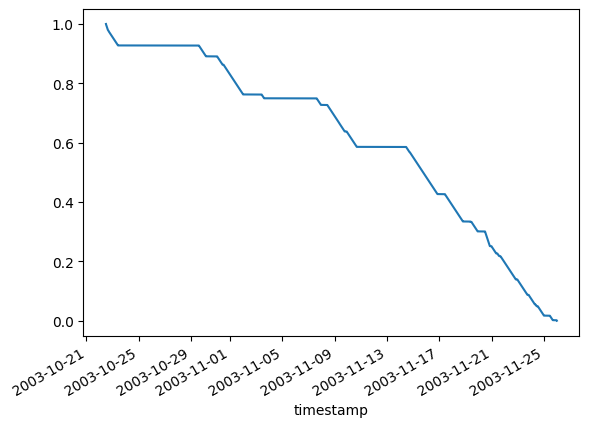

In [29]:
processed_data['RUL'].plot()

In [30]:
def get_model(context_length, horizon_length):
    hparams = TimesFmHparams(
        backend="torch",
        context_len=context_length,
        horizon_len=horizon_length,
        input_patch_len=32,
        output_patch_len=128,
        num_layers=20,
        model_dims=1280,
    )
    checkpoint = TimesFmCheckpoint(
        huggingface_repo_id="google/timesfm-1.0-200m-pytorch"
    )
    print(f"Initializing TimesFM with context_len={hparams.context_len}, horizon_len={hparams.horizon_len}")
    tfm = timesfm.TimesFm(hparams=hparams, checkpoint=checkpoint)
    return tfm


In [31]:
import timesfm

from timesfm import TimesFm, TimesFmHparams, TimesFmCheckpoint
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error # Added for MSE calculation


In [32]:
context_length =256
horizon_length = 32

tfm = get_model(context_length, horizon_length)

print("TimesFM model loaded successfully!")


Initializing TimesFM with context_len=256, horizon_len=32


Fetching 3 files: 100%|████████████████████████| 3/3 [00:00<00:00, 58525.17it/s]


TimesFM model loaded successfully!


In [33]:
data = processed_data[['mean','std','kurtosis']]

In [34]:
total_data_needed = context_length + horizon_length
if len(data) < total_data_needed:
    print(f"Not enough data downloaded. Need at least {total_data_needed} data points.")
    print(f"Only found {len(data)}. Please adjust context_length or horizon_length, or get more data.")
    

# Take the required portion of data from the end
data_for_analysis = data[-total_data_needed:]

historical_data_for_input = data_for_analysis[:context_length]
# The actual future data that we want to compare our forecast against
actual_future_data = data_for_analysis[context_length:]

# Prepare input for forecasting
# Ensure it's a list of numpy arrays or lists
forecast_input = [historical_data_for_input['mean'].values,historical_data_for_input['std'].values,historical_data_for_input['kurtosis'].values]


In [35]:
#forecast_input

In [37]:
frequency_input = [0,0,0]  # Assuming unknown frequency as before

print("\nPerforming forecast...")
point_forecast, point_forecast_2= tfm.forecast(
    forecast_input,
    freq=frequency_input,
)
predicted_future = point_forecast[0]


Performing forecast...


In [38]:
futures_data = actual_future_data

In [39]:
futures_data.shape

(32, 3)

In [44]:
futures_data['predicted_mean'] = point_forecast[0]
futures_data['predicted_std'] = point_forecast[1]
futures_data['predicted_kurtosis'] = point_forecast[2]

/var/folders/tz/k1k21d6x7j1d90h0t6dqf5yc0000gn/T/ipykernel_54043/2891879528.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  futures_data['predicted_mean'] = point_forecast[0]
/var/folders/tz/k1k21d6x7j1d90h0t6dqf5yc0000gn/T/ipykernel_54043/2891879528.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  futures_data['predicted_std'] = point_forecast[1]
/var/folders/tz/k1k21d6x7j1d90h0t6dqf5yc0000gn/T/ipykernel_54043/2891879528.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice

<Axes: xlabel='timestamp'>

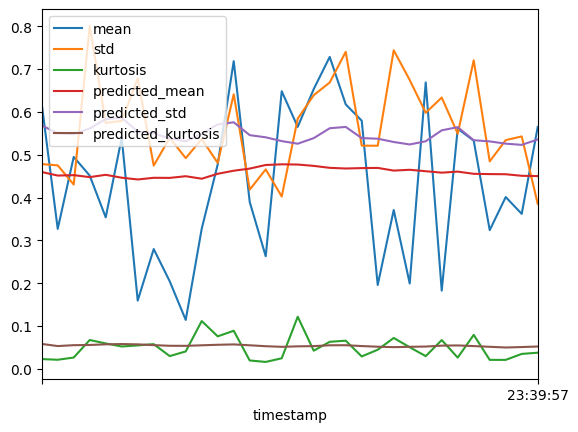

In [45]:
futures_data.plot()

In [42]:
futures_data['predicted_mean'] = predicted_future

/var/folders/tz/k1k21d6x7j1d90h0t6dqf5yc0000gn/T/ipykernel_54043/4169091656.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  futures_data['predicted_mean'] = predicted_future


In [43]:
def calculate_mse(actual, predicted):
    """
    Calculates the Mean Squared Error (MSE) between actual and predicted values.
    """
    return mean_squared_error(actual, predicted)


In [ ]:
# min_len = min(len(actual_future_data), len(predicted_future))
# mse = calculate_mse(actual_future_data[:min_len], predicted_future[:min_len])
# print(f"\nMean Squared Error (MSE): {mse:.4f}")

In [46]:
predicted_future

array([0.45954672, 0.4512417 , 0.4522218 , 0.44762936, 0.4529988 ,
       0.44623405, 0.44211614, 0.4460283 , 0.44582376, 0.44973567,
       0.44387004, 0.45541114, 0.46253476, 0.46754712, 0.47594383,
       0.47751737, 0.4769913 , 0.4738654 , 0.46930718, 0.46774527,
       0.4686803 , 0.46911868, 0.4628716 , 0.4647449 , 0.46137694,
       0.45804173, 0.4604457 , 0.45533428, 0.45470613, 0.4543272 ,
       0.45071146, 0.45003387], dtype=float32)

In [52]:
sum(actual_future_data['predicted_mean']-actual_future_data['mean']**2)/len(actual_future_data)

0.2396006308543697